**차원 축소**

특성이 너무 많으면 훈련을 느리게 할 뿐만 아니라, 좋은 솔루션을 찾기 어려움
- 이러한 문제를 **차원의 저주**라고 함
---
- 다행히 특성 수를 크게 줄여서 불가능한 문제를 가능한 범위로 변경할 수 있는 경우가 많음
- 훈련 속도를 높이는 것 외에 차원 축소는 데이터 시각화에도 아주 유용함
- 시각적인 패턴을 감지해 중요한 통찰을 얻는 경우가 많음


<font color="red">데이터 시각화를 하여 최종 결과를 사용함</font>

# 차원의 저주

고차원은 직관적으로 상상하기 어려움

- 두점 사이의 거리가 대략 0.52이었던 것이 3차원 큐브에서는 0.66, 1,000,000차원의 초입방체에서는 408.25임
    - 전혀 직관적이지 않음
- 고차원에서는 **많은 공간**을 가지고 있기 때문임
- 고차원 데이터셋은 매우 희박할 위험이 있음
    - 대부분의 훈련 데이터가 서로 멀리 떨어져 있음
---
<font color="blue">저차원일 때보다 예측이 더 불안정하고 훈련 세트의 차원이 클수록 과대적합 위험이 커짐</font>

- 차원의 저주를 해결하는 방법은 훈련 샘플의 밀도가 충분히 높아질 대까지 훈련 세트의 크기를 키우는 것임
    - 하지만 일정 밀도에 도달하기 위해 필요한 훈련 샘플 수는 차원 수가 커짐에 따라 기하급수적으로 늘어남
    

# 차원 축소를 위한 접근 방법

투영과 매니폴드 학습

## 투영

대부분 훈련 샘플이 모든 차원에 걸쳐 균일하게 퍼져 있지 않음
- 많은 특성은 거의 변화가 없는 반면, 다른 특성들은 서로 강하게 연관되어 있음
- 결과적으로 모든 훈련 샘플이 고차원 공간 안의 저차원 **부분 공간**에 놓여 있음

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)


In [2]:
np.random.seed(4)
m = 60
w1, w2 = 0.1, 0.3
noise = 0.1

angles = np.random.rand(m) * 3 * np.pi / 2 - 0.5
X = np.empty((m, 3))
X[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * np.random.randn(m) / 2
X[:, 1] = np.sin(angles) * 0.7 + noise * np.random.randn(m) / 2
X[:, 2] = X[:, 0] * w1 + X[:, 1] * w2 + noise * np.random.randn(m)

In [3]:
X_centered = X - X.mean(axis=0)
U, s, Vt = np.linalg.svd(X_centered)
c1 = Vt.T[:, 0]
c2 = Vt.T[:, 1]

In [4]:
m, n = X.shape

S = np.zeros(X_centered.shape)
S[:n, :n] = np.diag(s)

In [5]:
np.allclose(X_centered, U.dot(S).dot(Vt))

True

In [6]:
W2 = Vt.T[:, :2]
X2D = X_centered.dot(W2)

In [7]:
X2D_using_svd = X2D

In [8]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X2D = pca.fit_transform(X)

In [9]:
np.allclose(X2D, -X2D_using_svd)

True

In [10]:
X3D_inv = pca.inverse_transform(X2D)

In [11]:
np.allclose(X3D_inv, X)

False

In [12]:
X3D_inv_using_svd = X2D_using_svd.dot(Vt[:2, :])

In [13]:
np.allclose(X3D_inv_using_svd, X3D_inv - pca.mean_)

True

In [14]:
pca.components_

array([[-0.93636116, -0.29854881, -0.18465208],
       [ 0.34027485, -0.90119108, -0.2684542 ]])

In [15]:
Vt[:2]

array([[ 0.93636116,  0.29854881,  0.18465208],
       [-0.34027485,  0.90119108,  0.2684542 ]])

In [16]:
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d

class Arrow3D(FancyArrowPatch):
    def __init__(self, xs, ys, zs, *args, **kwargs):
        FancyArrowPatch.__init__(self, (0,0), (0,0), *args, **kwargs)
        self._verts3d = xs, ys, zs

    def draw(self, renderer):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
        self.set_positions((xs[0],ys[0]),(xs[1],ys[1]))
        FancyArrowPatch.draw(self, renderer)

In [17]:
axes = [-1.8, 1.8, -1.3, 1.3, -1.0, 1.0]

x1s = np.linspace(axes[0], axes[1], 10)
x2s = np.linspace(axes[2], axes[3], 10)
x1, x2 = np.meshgrid(x1s, x2s)

C = pca.components_
R = C.T.dot(C)
z = (R[0, 2] * x1 + R[1, 2] * x2) / (1 - R[2, 2])

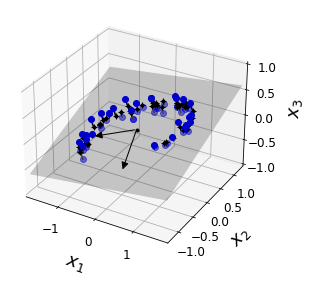

_파이썬 오류로 3D plot이 불가_

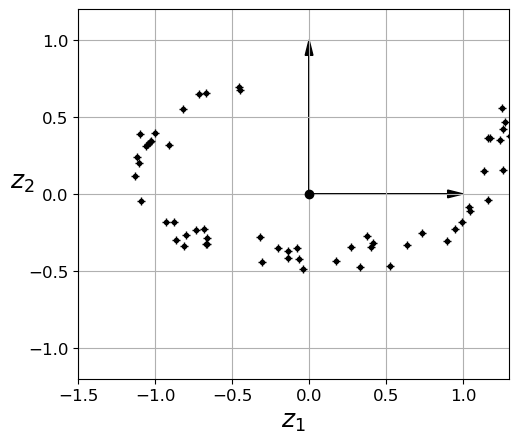

In [18]:
fig = plt.figure()
ax = fig.add_subplot(111, aspect='equal')

ax.plot(X2D[:, 0], X2D[:, 1], "k+")
ax.plot(X2D[:, 0], X2D[:, 1], "k.")
ax.plot([0], [0], "ko")
ax.arrow(0, 0, 0, 1, head_width=0.05, length_includes_head=True, head_length=0.1, fc='k', ec='k')
ax.arrow(0, 0, 1, 0, head_width=0.05, length_includes_head=True, head_length=0.1, fc='k', ec='k')
ax.set_xlabel("$z_1$", fontsize=18)
ax.set_ylabel("$z_2$", fontsize=18, rotation=0)
ax.axis([-1.5, 1.3, -1.2, 1.2])
ax.grid(True)
# save_fig("dataset_2d_plot")

- 모든 훈련 샘플이 거의 평면 형태로 놓여 있음
- 모든 훈련 샘플을 이 부분 공간에 수직으로 투영하면 위와 같은 2D 데이터셋을 얻음

투영이 최선의 방법이 아님
- **스위스 롤** 데이터셋처럼 부분 공간이 뒤틀리거나 휘어 있기도 함

In [19]:
from sklearn.datasets import make_swiss_roll

X, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=42)

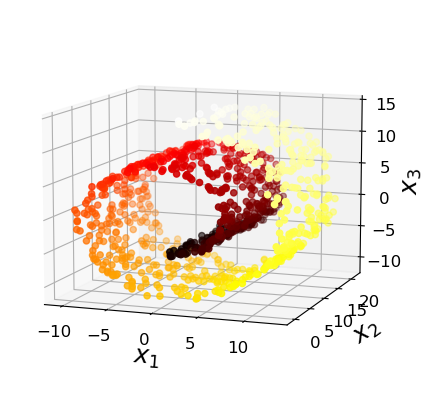

In [20]:
axes = [-11.5, 14, -2, 23, -12, 15]

fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=t, cmap=plt.cm.hot)
ax.view_init(10, -70)
ax.set_xlabel("$x_1$", fontsize=18)
ax.set_ylabel("$x_2$", fontsize=18)
ax.set_zlabel("$x_3$", fontsize=18)
ax.set_xlim(axes[0:2])
ax.set_ylim(axes[2:4])
ax.set_zlim(axes[4:6])

# save_fig("swiss_roll_plot")
plt.show()

- 그냥 평면에 투영시키면 왼쪽처럼 스위스 롤의 층이 서로 뭉개짐
- 우리가 원하는 것은 스위스 롤을 펼쳐서 오른쪽처럼 2D 데이터셋을 얻는 것임

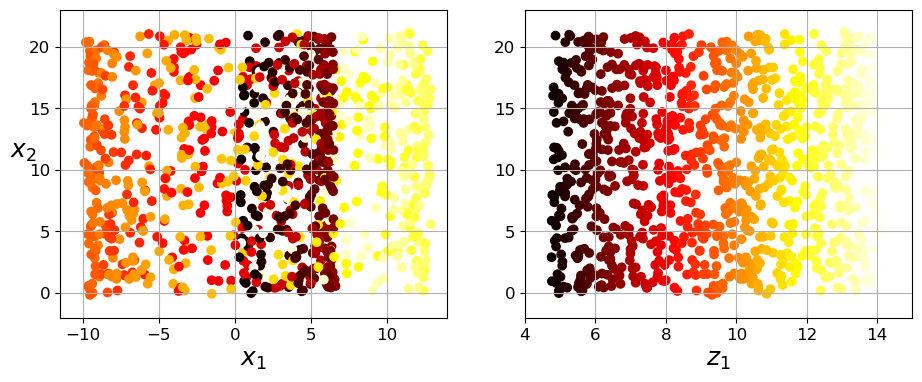

In [21]:
plt.figure(figsize=(11, 4))

plt.subplot(121)
plt.scatter(X[:, 0], X[:, 1], c=t, cmap=plt.cm.hot)
plt.axis(axes[:4])
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$x_2$", fontsize=18, rotation=0)
plt.grid(True)

plt.subplot(122)
plt.scatter(t, X[:, 1], c=t, cmap=plt.cm.hot)
plt.axis([4, 15, axes[2], axes[3]])
plt.xlabel("$z_1$", fontsize=18)
plt.grid(True)

# save_fig("squished_swiss_roll_plot")
plt.show()

## 매니폴드 학습

스위스 롤은 2D **매니폴드**의 한 예임
- 즉, 2D 매니폴드는 고차원 공간에서 휘어지거나 뒤틀린 2D 모양임
- 더 일반적으로 d차원 매니폴드는 국부적으로 d차원 초평면으로 보일 수 있는 n차원 공간의 일부임 (d < n)
- 스위스 롤의 경우에는 d=2이고 n=3임
- 국부적으로 2D 평면으로 보이지만 3차원으로 말려 있음

---
- 많은 차원 축소 알고리즘이 훈련 샘플이 놓여 있는 **매니폴드**를 모델링하는 식으로 작동함
    - 이를 **매니폴드 학습**이라고 함
    - 대부분 실제 고차원 데이터셋이 더 낮은 저차원 매니폴드에 가깝게 놓여 있다는 **매니폴드 가정** 또는 **매니폴드 가설**에 근거함

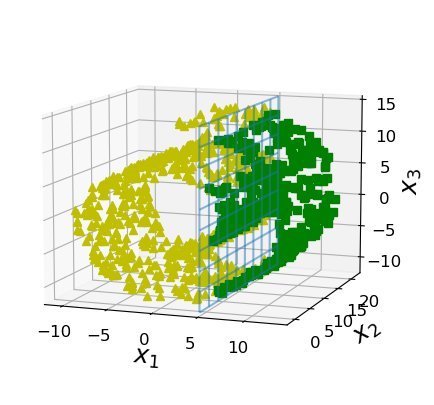

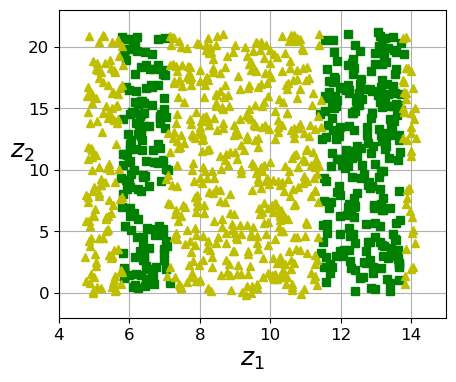

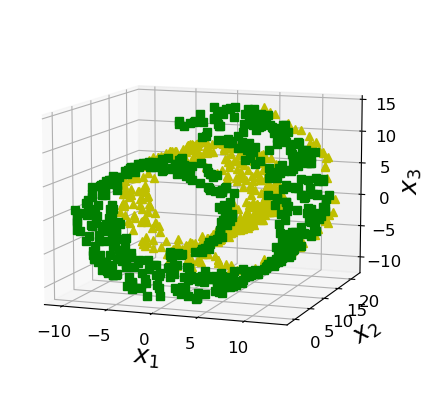

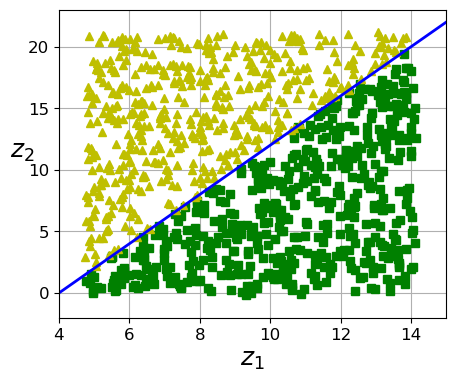

In [22]:
from matplotlib import gridspec

axes = [-11.5, 14, -2, 23, -12, 15]

x2s = np.linspace(axes[2], axes[3], 10)
x3s = np.linspace(axes[4], axes[5], 10)
x2, x3 = np.meshgrid(x2s, x3s)

fig = plt.figure(figsize=(6, 5))
ax = plt.subplot(111, projection='3d')

positive_class = X[:, 0] > 5
X_pos = X[positive_class]
X_neg = X[~positive_class]
ax.view_init(10, -70)
ax.plot(X_neg[:, 0], X_neg[:, 1], X_neg[:, 2], "y^")
ax.plot_wireframe(5, x2, x3, alpha=0.5)
ax.plot(X_pos[:, 0], X_pos[:, 1], X_pos[:, 2], "gs")
ax.set_xlabel("$x_1$", fontsize=18)
ax.set_ylabel("$x_2$", fontsize=18)
ax.set_zlabel("$x_3$", fontsize=18)
ax.set_xlim(axes[0:2])
ax.set_ylim(axes[2:4])
ax.set_zlim(axes[4:6])

# save_fig("manifold_decision_boundary_plot1")
plt.show()

fig = plt.figure(figsize=(5, 4))
ax = plt.subplot(111)

plt.plot(t[positive_class], X[positive_class, 1], "gs")
plt.plot(t[~positive_class], X[~positive_class, 1], "y^")
plt.axis([4, 15, axes[2], axes[3]])
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18, rotation=0)
plt.grid(True)

# save_fig("manifold_decision_boundary_plot2")
plt.show()

fig = plt.figure(figsize=(6, 5))
ax = plt.subplot(111, projection='3d')

positive_class = 2 * (t[:] - 4) > X[:, 1]
X_pos = X[positive_class]
X_neg = X[~positive_class]
ax.view_init(10, -70)
ax.plot(X_neg[:, 0], X_neg[:, 1], X_neg[:, 2], "y^")
ax.plot(X_pos[:, 0], X_pos[:, 1], X_pos[:, 2], "gs")
ax.set_xlabel("$x_1$", fontsize=18)
ax.set_ylabel("$x_2$", fontsize=18)
ax.set_zlabel("$x_3$", fontsize=18)
ax.set_xlim(axes[0:2])
ax.set_ylim(axes[2:4])
ax.set_zlim(axes[4:6])

# save_fig("manifold_decision_boundary_plot3")
plt.show()

fig = plt.figure(figsize=(5, 4))
ax = plt.subplot(111)

plt.plot(t[positive_class], X[positive_class, 1], "gs")
plt.plot(t[~positive_class], X[~positive_class, 1], "y^")
plt.plot([4, 15], [0, 22], "b-", linewidth=2)
plt.axis([4, 15, axes[2], axes[3]])
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18, rotation=0)
plt.grid(True)

# save_fig("manifold_decision_boundary_plot4")
plt.show()

- 매니폴드의 가정은 종종 암묵적으로 다른 가정과 병행되곤 함
- 바로 처리해야 할 작업이 저차원의 매니폴드 공간에 표현되면 더 간단해질 것이란 가정임
- 세 번째 그림에서는 스위스 롤이 두 개의 클래스로 나뉘어 있음
- 3D에서는 결정 경계가 매우 복잡하지만 펼쳐진 매니폴드 공간인 2Dㅇ에서는 결정 경계가 단순한 직선임
---
- 하지만 첫 번째 그림 경우 $x_1=5$에 결정 경계가 있음
- 이 결정 경계는 3D 공간에서는 매우 단순함
- 하지만 펼쳐진 매니폴드에서는 결정 경계가 더 복잡해짐(4개의 수직선)

---
요약하자면 모델을 훈련시키기 전에 훈련 세트의 차원을 감소시키면 훈련 속도는 빨라지지만 항상 더 낫거나 간단한 솔루션이 되는 것은 아님
- 전적으로 데이터셋에 달려 있음

# PCA

**주성분 분석(PCA)**는 가장 인기 있는 차원 축소 알고리즘임
- 데이터에서 가장 가까운 초평면을 정의한 다음, 이 평면에 데이터를 투영시킴

## 분산 보존

올바른 초평면을 선택해야함

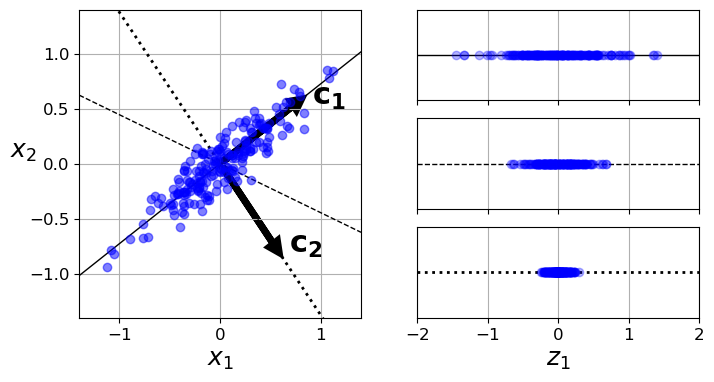

In [23]:
angle = np.pi / 5
stretch = 5
m = 200

np.random.seed(3)
X = np.random.randn(m, 2) / 10
X = X.dot(np.array([[stretch, 0],[0, 1]])) # stretch
X = X.dot([[np.cos(angle), np.sin(angle)], [-np.sin(angle), np.cos(angle)]]) # rotate

u1 = np.array([np.cos(angle), np.sin(angle)])
u2 = np.array([np.cos(angle - 2 * np.pi/6), np.sin(angle - 2 * np.pi/6)])
u3 = np.array([np.cos(angle - np.pi/2), np.sin(angle - np.pi/2)])

X_proj1 = X.dot(u1.reshape(-1, 1))
X_proj2 = X.dot(u2.reshape(-1, 1))
X_proj3 = X.dot(u3.reshape(-1, 1))

plt.figure(figsize=(8,4))
plt.subplot2grid((3,2), (0, 0), rowspan=3)
plt.plot([-1.4, 1.4], [-1.4*u1[1]/u1[0], 1.4*u1[1]/u1[0]], "k-", linewidth=1)
plt.plot([-1.4, 1.4], [-1.4*u2[1]/u2[0], 1.4*u2[1]/u2[0]], "k--", linewidth=1)
plt.plot([-1.4, 1.4], [-1.4*u3[1]/u3[0], 1.4*u3[1]/u3[0]], "k:", linewidth=2)
plt.plot(X[:, 0], X[:, 1], "bo", alpha=0.5)
plt.axis([-1.4, 1.4, -1.4, 1.4])
plt.arrow(0, 0, u1[0], u1[1], head_width=0.1, linewidth=5, length_includes_head=True, head_length=0.1, fc='k', ec='k')
plt.arrow(0, 0, u3[0], u3[1], head_width=0.1, linewidth=5, length_includes_head=True, head_length=0.1, fc='k', ec='k')
plt.text(u1[0] + 0.1, u1[1] - 0.05, r"$\mathbf{c_1}$", fontsize=22)
plt.text(u3[0] + 0.1, u3[1], r"$\mathbf{c_2}$", fontsize=22)
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$x_2$", fontsize=18, rotation=0)
plt.grid(True)

plt.subplot2grid((3,2), (0, 1))
plt.plot([-2, 2], [0, 0], "k-", linewidth=1)
plt.plot(X_proj1[:, 0], np.zeros(m), "bo", alpha=0.3)
plt.gca().get_yaxis().set_ticks([])
plt.gca().get_xaxis().set_ticklabels([])
plt.axis([-2, 2, -1, 1])
plt.grid(True)

plt.subplot2grid((3,2), (1, 1))
plt.plot([-2, 2], [0, 0], "k--", linewidth=1)
plt.plot(X_proj2[:, 0], np.zeros(m), "bo", alpha=0.3)
plt.gca().get_yaxis().set_ticks([])
plt.gca().get_xaxis().set_ticklabels([])
plt.axis([-2, 2, -1, 1])
plt.grid(True)

plt.subplot2grid((3,2), (2, 1))
plt.plot([-2, 2], [0, 0], "k:", linewidth=2)
plt.plot(X_proj3[:, 0], np.zeros(m), "bo", alpha=0.3)
plt.gca().get_yaxis().set_ticks([])
plt.axis([-2, 2, -1, 1])
plt.xlabel("$z_1$", fontsize=18)
plt.grid(True)

# save_fig("pca_best_projection_plot")
plt.show()

- 왼쪽 그래프는 간단한 2D 데이터셋이 세 개의 축과 함께 표현되어 있음
- 오른쪽 그래프는 데이터셋이 각 축에 투영된 결과임
- 실선에 투영된 것은 분산을 최대로 보존하는 반면, 점선에 투영된 것은 분산을 매우 적게 유지하고 있음

- 분산이 최대로 보존되는 축을 선택하는 것이 정보가 가장 적게 손실되므로 합리적임
    - 원본 데이터셋과 투영된 것 사이의 평균 제곱 거리를 최소화하는 축임

## 주성분

- PCA는 훈련 세트에서 분산이 최대인 축을 찾음
- 첫 번째 축에 직교하여 남은 분산을 최대한 보존하는 두 번째 축을 찾음
- 세 번째 축은 두 축에 직교하는 축임
- 데이터셋에 있는 차원의 수만큼 네 번째, 다섯 번째, ... n번째 축을 찾음
---
- i번째 축을 이 데이터의 i번째 **주성분**이라고 부름
- 첫번째 PC는 벡터 $c_1$이 놓인 축이고 두 번째 PC는 벡터 $c_2$가 놓인 축임
- 처음 두 개의 PC는 두 화살표가 놓인 평면의 수직 축임
- 세 번째 PC는 이 평면에서 수직임

<font color="blue">특잇값 분해(SVD)로 주성분을 찾음

- 훈련 세트 행렬 X를 세 개 행렬의 행렬 곱인 $U\sum V^T$로 분해할 수 있음
- 모든 주성분의 단위 벡터가 V에 같이 담겨져 있음

**주성분 행렬**

$V=\begin{pmatrix}
\mid \ \mid \qquad \mid \\
c_1 \ c_2 \cdots c_n \\
\mid \ \mid \qquad \mid 
\end{pmatrix}$

- svd()함수를 사용해 주성분을 구한 후 처음 두 개의 PC를 정의하는 두 개의 단위 벡터를 추출함

In [24]:
X_centered = X - X.mean(axis=0)
U, s, Vt = np.linalg.svd(X_centered)
c1 = Vt.T[:, 0]
c2 = Vt.T[:, 1]

## d차원으로 투영하기

주성분을 모두 추출해냈다면 처음 d차원 주성분으로 정의한 초평면에 투영하여 데이터셋의 차원을 d차원으로 축소시킬 수 있음
- 초평면은 분산을 가능한 한 최대로 보존하는 투영임을 보장함

- 초평면에 훈련 세트를 투영하고 d차원으로 축소된 데이터셋 $X^{d-proj}$을 얻기 위해서는 행렬 X와 V의 첫 d열로 구성된 행렬 $W_d$를 행렬 곱셈하면 됨

**훈련 세트를 d차원으로 투영하기**

$X_{d-proj}=XW_d$

- 다음 파이썬 코드는 첫 두 개의 주성분으로 정의된 평면에 훈련 세트를 투영함

In [25]:
W2 = Vt.T[:, :2]
X2D = X_centered.dot(W2)

## 사이킷런 사용하기

사이킷런 PCA 모델은 앞서 한 것처럼 SVD 분해 방법을 사용하여 구현함
- 다음은 PCA 모델을 사용해 데이터셋의 차원을 2로 줄이는 코드임

In [26]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X2D = pca.fit_transform(X)

- PCA 변환기를 데이터셋에 학습시키고 나면 components_ 속성에 $W^d$의 전치가 담겨 있음

## 설명된 분산의 비율

explained_variance_ratio_ 변수에 저장된 주성분의 **설명된 분산의 비율**도 유용한 정보 중 하나임

- 이 비율은 각 주성분의 축을 따라 데이터셋의 분산 비율을 나타냄

In [27]:
pca.explained_variance_ratio_

array([0.95369864, 0.04630136])

- 이 데이터셋은 분산의 95.4%가 첫 번째 PC를 따라 놓여 있고 4.6%가 두 번째 PC를 따라 놓여 있음을 알려줌
    - 세 번째는 매우 적은 양의 정보가 들어있다고 판단

## 적절한 차원 수 선택하기

축소할 차원 수를 임의로 정하기보다는 충분한 분산이 될 때까지 더해야 할 차원 수를 선택하는 것이 간단함
- 데이터 시각화를 위해 차원을 축소하는 경우에는 차원을 2개나 3개로 줄이는 것이 일반적임

- 차원을 축소하지 않고 PCA를 계산한 뒤 훈련 세트의 분산을 95%로 유지하는 데 필요한 최소한의 차원 수를 계산함

In [28]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1, as_frame=False)
mnist.target = mnist.target.astype(np.uint8)

In [29]:
from sklearn.model_selection import train_test_split

X = mnist["data"]
y = mnist["target"]

X_train, X_test, y_train, y_test = train_test_split(X, y)

In [30]:
pca = PCA()
pca.fit(X_train)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1

- 그런 다음 n_components=d로 설정하여 PCA를 다시 실행함
- 하지만 유지하려는 주성분의 수를 지정하기보다는 보존하려는 분산의 비율을 n_components에 0.0에서 1.0사이로 설정하는 편이 훨씬 나음

In [31]:
pca = PCA(n_components=0.95)
X_reduced = pca.fit_transform(X_train)

- 또 다른 방법은 설명된 분산을 차원 수에 대한 함수로 그리는 것임
- 일반적으로 이 그래프에는 설명된 분산의 빠른 성장이 멈추는 변곡점이 있음
- 여기서는 차원을 약 100으로 축소해도 설명된 분산을 크게 손해보지 않을 것임

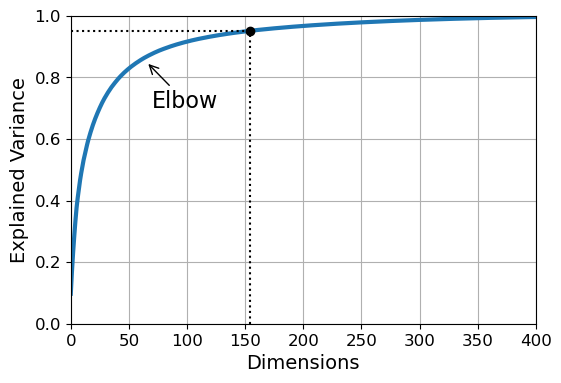

In [32]:
plt.figure(figsize=(6,4))
plt.plot(cumsum, linewidth=3)
plt.axis([0, 400, 0, 1])
plt.xlabel("Dimensions")
plt.ylabel("Explained Variance")
plt.plot([d, d], [0, 0.95], "k:")
plt.plot([0, d], [0.95, 0.95], "k:")
plt.plot(d, 0.95, "ko")
plt.annotate("Elbow", xy=(65, 0.85), xytext=(70, 0.7),
             arrowprops=dict(arrowstyle="->"), fontsize=16)
plt.grid(True)
# save_fig("explained_variance_plot")
plt.show()

## 압축을 위한 PCA

차원을 축소하고 난 후에는 훈련 세트의 크기가 줄어듦
- MNIST 데이터셋에 분산의 95%를 유지하도록 PCA를 적용해보겠음
- 784개의 특성이 아닌 150개 정도만 가지고 있을 것임
- 대부분의 분산은 유지되었지만 데이터셋은 원본 크기의 20% 미만이 됨
    - 상당한 압축률에 SVM 같은 분류 알고리즘의 속도를 크게 높일 수 있음

- 압축된 데이터셋에 PCA 투영의 변환을 반대로 적용하여 784개의 차원으로 되돌릴 수 있음
- 투영에서 일정량의 정보를 잃어버렸기 때문에 이렇게 해도 원본 데이터셋을 얻을 수는 없음
    - 하지만 비슷할 것임
- 원본 데이터와 재구성된 데이터 사이의 평균 제곱 거리를 **재구성 오차**라고 함

- ```inverse_transform()```으로 784차원으로 복원함

In [33]:
pca = PCA(n_components=154)
X_reduced = pca.fit_transform(X_train)
X_recovered = pca.inverse_transform(X_reduced)

In [34]:
# EXTRA
def plot_digits(instances, images_per_row=5, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    # This is equivalent to n_rows = ceil(len(instances) / images_per_row):
    n_rows = (len(instances) - 1) // images_per_row + 1

    # Append empty images to fill the end of the grid, if needed:
    n_empty = n_rows * images_per_row - len(instances)
    padded_instances = np.concatenate([instances, np.zeros((n_empty, size * size))], axis=0)

    # Reshape the array so it's organized as a grid containing 28×28 images:
    image_grid = padded_instances.reshape((n_rows, images_per_row, size, size))

    # Combine axes 0 and 2 (vertical image grid axis, and vertical image axis),
    # and axes 1 and 3 (horizontal axes). We first need to move the axes that we
    # want to combine next to each other, using transpose(), and only then we
    # can reshape:
    big_image = image_grid.transpose(0, 2, 1, 3).reshape(n_rows * size,
                                                         images_per_row * size)
    # Now that we have a big image, we just need to show it:
    plt.imshow(big_image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

Text(0.5, 1.0, 'Compressed')

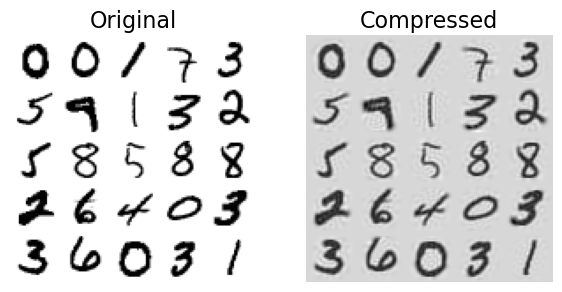

In [35]:
plt.figure(figsize=(7, 4))
plt.subplot(121)
plot_digits(X_train[::2100])
plt.title("Original", fontsize=16)
plt.subplot(122)
plot_digits(X_recovered[::2100])
plt.title("Compressed", fontsize=16)

# save_fig("mnist_compression_plot")

- 원본과 거의 비슷함

**PCA 역변환**

$X_{recovered}=X_{d-proj}W_d^T$

## 랜덤 PCA

- ```svd_solver``` 매개변수를 "randomized"로 지정하면 사이킷런은 랜덤 PCA라 부르는 확률적 알고리즘을 사용해 처음 d개의 주성분에 대한 근삿값을 빠르게 찾음
- 이 알고리즘의 계산 복잡도는 완전한 SVD 방식인 $O(m\times n^2)+O(n^3)$이 아니라 $O(m\times d^2)+O(d^3)$임
- 따라서 d가 n보다 많이 작으면 완전 SVD보다 훨씬 빠름

In [36]:
rnd_pca = PCA(n_components=154, svd_solver="randomized")
X_reduced = rnd_pca.fit_transform(X_train)

- ```svd_solver```의 기본값은 "auto"임
- m이나 n이 500보다 크고 d가 m이나 n의 80%보다 작으면 사이킷런은 자동으로 랜덤 PCA 알고리즘을 사용함
- 아니면 완전한 SVD 방식을 사용함
- 사이킷런에서 완전한 SVD 방식을 강제하려면 svd_solver 매개변수를 "full"로 지정함

## 점진적 PCA

PCA 구현의 문제는 SVD 알고리즘을 실행하기 위해 전체 훈련 세트를 메모리에 올려야 함
- 다행히 **점진적 PCA (incremental PCA : IPCA)** 알고리즘이 개발됨
- 훈련 세트를 미니배치로 나눈 뒤 IPCA 알고리즘에 한 번에 하나씩 주입됨
- 이런 방식은 훈련 세트가 클 때 유용하고 온라인으로 PCA를 적용할 수 있음

- MNIST 데이터셋을 100개의 미니배치로 나누고 사이킷런의 IncrementalPCA 파이썬 클래스에 주입하여 MNIST 데이터셋의 차원을 154개로 줄임
- 전체 훈련 세트를 사용하는 fit() 메서드가 아니라 partial_fit() 메서드를 미니배치마다 호출해야함

In [37]:
from sklearn.decomposition import IncrementalPCA

n_batches = 100
inc_pca = IncrementalPCA(n_components=154)
for X_batch in np.array_split(X_train, n_batches):
    inc_pca.partial_fit(X_batch)

X_reduced = inc_pca.transform(X_train)

- 또 다른 방법은 넘파이의 memmap 파이썬 클래스를 사용해 하드 디스크의 이진 파일에 저장된 매우 큰 배열을 메모리에 들어 있는 것처럼 다루는 것임
- 이 파이썬 클래스는 필요할 때 데이터를 메모리에 적재함
- IncrementalPCA는 특정 순간에 배열의 일부만 사용하기 때문에 메모리 부족 문제를 해결할 수 있음
- 일반적인 fit() 매서드를 사용할 수 있음

In [38]:
filename = "my_mnist.data"
m, n = X_train.shape

X_mm = np.memmap(filename, dtype='float32', mode='write', shape=(m, n))
X_mm[:] = X_train
del X_mm

In [39]:
X_mm = np.memmap(filename, dtype="float32", mode="readonly", shape=(m,n))

batch_size = m // n_batches
inc_pca = IncrementalPCA(n_components=154, batch_size=batch_size)
inc_pca.fit(X_mm)

IncrementalPCA(batch_size=525, n_components=154)

In [40]:
import time

for n_components in (2, 10, 154):
    print("n_components =", n_components)
    regular_pca = PCA(n_components=n_components, svd_solver="full")
    inc_pca = IncrementalPCA(n_components=n_components, batch_size=500)
    rnd_pca = PCA(n_components=n_components, random_state=42, svd_solver="randomized")

    for name, pca in (("PCA", regular_pca), ("Inc PCA", inc_pca), ("Rnd PCA", rnd_pca)):
        t1 = time.time()
        pca.fit(X_train)
        t2 = time.time()
        print("    {}: {:.1f} seconds".format(name, t2 - t1))

n_components = 2
    PCA: 5.0 seconds
    Inc PCA: 8.8 seconds
    Rnd PCA: 1.1 seconds
n_components = 10
    PCA: 5.0 seconds
    Inc PCA: 9.7 seconds
    Rnd PCA: 1.3 seconds
n_components = 154
    PCA: 5.1 seconds
    Inc PCA: 12.6 seconds
    Rnd PCA: 3.2 seconds


Text(0.5, 1.0, 'PCA and Randomized PCA time complexity ')

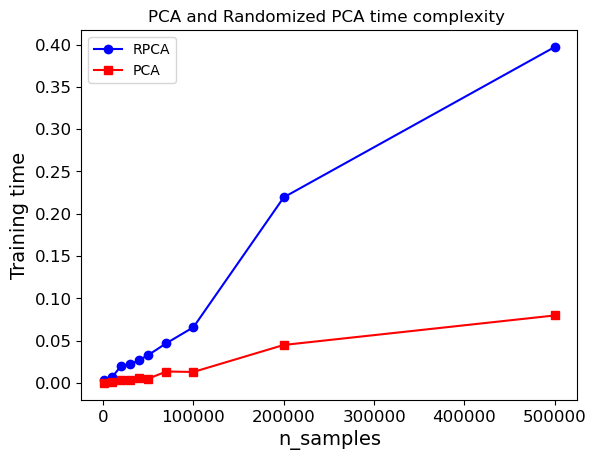

In [41]:
times_rpca = []
times_pca = []
sizes = [1000, 10000, 20000, 30000, 40000, 50000, 70000, 100000, 200000, 500000]
for n_samples in sizes:
    X = np.random.randn(n_samples, 5)
    pca = PCA(n_components=2, svd_solver="randomized", random_state=42)
    t1 = time.time()
    pca.fit(X)
    t2 = time.time()
    times_rpca.append(t2 - t1)
    pca = PCA(n_components=2, svd_solver="full")
    t1 = time.time()
    pca.fit(X)
    t2 = time.time()
    times_pca.append(t2 - t1)

plt.plot(sizes, times_rpca, "b-o", label="RPCA")
plt.plot(sizes, times_pca, "r-s", label="PCA")
plt.xlabel("n_samples")
plt.ylabel("Training time")
plt.legend(loc="upper left")
plt.title("PCA and Randomized PCA time complexity ")

Text(0.5, 1.0, 'PCA and Randomized PCA time complexity ')

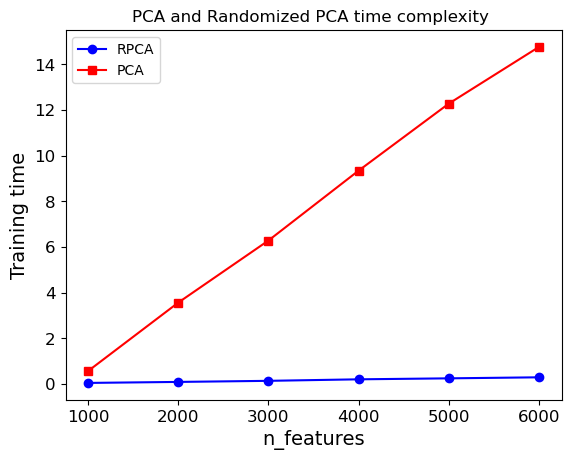

In [42]:
times_rpca = []
times_pca = []
sizes = [1000, 2000, 3000, 4000, 5000, 6000]
for n_features in sizes:
    X = np.random.randn(2000, n_features)
    pca = PCA(n_components=2, random_state=42, svd_solver="randomized")
    t1 = time.time()
    pca.fit(X)
    t2 = time.time()
    times_rpca.append(t2 - t1)
    pca = PCA(n_components=2, svd_solver="full")
    t1 = time.time()
    pca.fit(X)
    t2 = time.time()
    times_pca.append(t2 - t1)

plt.plot(sizes, times_rpca, "b-o", label="RPCA")
plt.plot(sizes, times_pca, "r-s", label="PCA")
plt.xlabel("n_features")
plt.ylabel("Training time")
plt.legend(loc="upper left")
plt.title("PCA and Randomized PCA time complexity ")

_시간 복잡도_

- 확률적 random pca가 확실히 빠르다는 것을 볼 수 있음

# 커널 PCA

5장에서 샘플을 매우 높은 고차원 공간(**특성 공간**)으로 암묵적으로 매핑하여 서포트 벡터 머신의 비선형 분류와 회귀를 가능하게 하는 수학적 기법인 커널 트릭에 대해 이야기 했음
- 고차원 특성 공간에서의 선형 결정 경계는 **원본 공간**에서는 복잡한 비선형 결정 경계에 해당함

- 같은 기법을 PCA에 적용해 차원 축소를 위한 복잡한 비선형 투형을 수행할 수 있음
- 이를 커널 PCA(kPCA)라고 함
- 이 기법은 투영된 후에 샘플의 군집을 유지하거나 꼬인 매니폴드에 가까운 데이터셋을 펼칠 때도 유용함

In [43]:
X, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=42)

In [44]:
from sklearn.decomposition import KernelPCA

rbf_pca = KernelPCA(n_components=2, kernel="rbf", gamma=0.04)
X_reduced = rbf_pca.fit_transform(X)

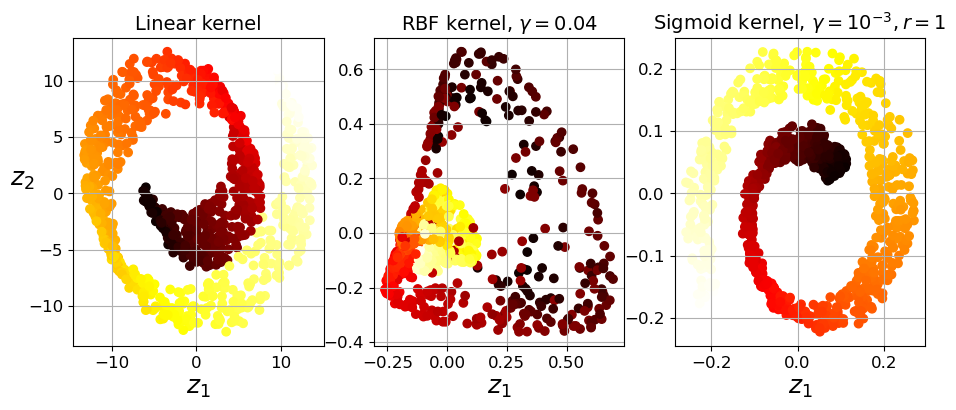

In [45]:
from sklearn.decomposition import KernelPCA

lin_pca = KernelPCA(n_components = 2, kernel="linear", fit_inverse_transform=True)
rbf_pca = KernelPCA(n_components = 2, kernel="rbf", gamma=0.0433, fit_inverse_transform=True)
sig_pca = KernelPCA(n_components = 2, kernel="sigmoid", gamma=0.001, coef0=1, fit_inverse_transform=True)

y = t > 6.9

plt.figure(figsize=(11, 4))
for subplot, pca, title in ((131, lin_pca, "Linear kernel"), (132, rbf_pca, "RBF kernel, $\gamma=0.04$"), (133, sig_pca, "Sigmoid kernel, $\gamma=10^{-3}, r=1$")):
    X_reduced = pca.fit_transform(X)
    if subplot == 132:
        X_reduced_rbf = X_reduced
    
    plt.subplot(subplot)
    #plt.plot(X_reduced[y, 0], X_reduced[y, 1], "gs")
    #plt.plot(X_reduced[~y, 0], X_reduced[~y, 1], "y^")
    plt.title(title, fontsize=14)
    plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.hot)
    plt.xlabel("$z_1$", fontsize=18)
    if subplot == 131:
        plt.ylabel("$z_2$", fontsize=18, rotation=0)
    plt.grid(True)

# save_fig("kernel_pca_plot")
plt.show()

_선형 커널, RBF 커널, 시그모이드 커널을 사용하여 2차원으로 축소시킨 스위스 롤의 모습임_

## 커널 선택과 하이퍼파라미터 튜닝

kPCA는 비지도 학습이기 때문에 좋은 커널과 하이퍼파라미터를 선택하기 위한 명확한 성능 측정 기준이 없음
- 차원 축소는 종종 지도 학습의 전처리 단계로 활용되므로 그리드 탐색을 사용하여 주어진 문제에서 성능이 가장 좋은 커널과 하이퍼파라미터를 선택할 수 있음
- 다음 코드는 두 단계의 파이프라인을 만드는데, 먼저 kPCA를 사용해 차원을 2차원으로 축소하고 분류를 위해 로지스틱 회귀를 적용함
- 그런 다음 파이프라인 마지막 단계에서 가장 높은 분류 정확도를 얻기 위해 GridSearchCV를 사용해 kPCA의 가장 좋은 커널과 gamma 파라미터를 찾음

In [46]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

clf = Pipeline([
    ("kpca", KernelPCA(n_components=2)),
    ("log_reg", LogisticRegression())
])

param_grid = [{
    "kpca__gamma":np.linspace(0.03, 0.05, 10),
    "kpca__kernel":["rbf", "sigmoid"]
}]

grid_search = GridSearchCV(clf, param_grid, cv=3)
grid_search.fit(X, y)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('kpca', KernelPCA(n_components=2)),
                                       ('log_reg', LogisticRegression())]),
             param_grid=[{'kpca__gamma': array([0.03      , 0.03222222, 0.03444444, 0.03666667, 0.03888889,
       0.04111111, 0.04333333, 0.04555556, 0.04777778, 0.05      ]),
                          'kpca__kernel': ['rbf', 'sigmoid']}])

In [47]:
print(grid_search.best_params_)

{'kpca__gamma': 0.043333333333333335, 'kpca__kernel': 'rbf'}


- 완전한 비지도 학습 방법으로, 가장 낮은 재구성 오차를 만드는 커널과 하이퍼파라미터를 선택하는 방식도 있음
    - 하지만 재구성은 선형 PCA 만큼 쉽지 않음
    

- 커널 트릭 덕분에 이 변환은 **특성 맵** $\phi$를 사용하여 훈련 세트를 무한 차원의 특성 공간에 매핑한 다음, 변환된 데이터셋을 선형 PCA를 사용해 2D로 투영한 것과 수학적으로 동일함

- 축소된 공간에 있는 샘플에 대해 선형 PCA를 역전시키면 재구성된 데이터 포인트는 원본 공간이 아닌 특성 공간에 놓이게 됨
- 이 특성 공간은 무한 차원이기 때문에 재구성된 포인트를 계산할 수 없고 재구성에 따른 실제 에러를 계산할 수 없음
- 다행히 재구성된 포인트에 가깝게 매핑된 원본 공간의 포인트를 찾을 수 있음
- 이를 **재구성 원상**이라고 부름
- 원상을 얻게 되면 원본 샘플과의 제곱 거리를 측정할 수 있음
- 재구성 원상의 오차를 최소화하는 커널과 하이퍼파라미터를 선택할 수 있음

- 투영된 샘플을 훈련 세트로, 원본 샘플을 타깃으로 하는 지도 학습 회귀 모델을 훈련시켜 재구성함

```fit_inverse_transform=True```로 지정하면 이를 자동으로 수행함

In [49]:
rbf_pca = KernelPCA(n_components=2, kernel="rbf", gamma=0.0433,
                   fit_inverse_transform=True)
X_reduced = rbf_pca.fit_transform(X)
X_preimage = rbf_pca.inverse_transform(X_reduced)

재구성 원상 오차를 계산할 수 있음

In [50]:
from sklearn.metrics import mean_squared_error
mean_squared_error(X, X_preimage)

32.78630879576614

이렇게 되면 재구성 원상 오차를 최소화하는 커널과 하이퍼파라미터를 찾기 위해 교차 검증으로 그리드 탐색을 사용할 수 있음